In [2]:
import sys
sys.path.append('../')
from config import *
from src.realtime_utils import *

In [3]:
from plotnine import *

In [4]:
def increase_dates_by_weeks(dates, weeks):
    """
    Increases all dates in the list (except the last one) by a given number of weeks.
    """
    date_series = pd.to_datetime(dates)
    updated_dates = date_series[:-1] + pd.to_timedelta(weeks, unit='W')
    updated_dates = updated_dates[(updated_dates <= '2024-09-12') & (updated_dates != '2023-12-28')]
    updated_dates = updated_dates.tolist() + [date_series[-1]]
    
    return [date.strftime('%Y-%m-%d') for date in updated_dates]

In [5]:
def load_nowcast_wide(date, location="DE", age_group="00+"):
    # Construct the file path
    file_path = f'../data/nowcasts/KIT-baseline/{date}-icosari-sari-KIT-baseline.csv'
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter based on location, age_group, and type
    df_filtered = df[
        (df['location'] == location) & 
        (df['age_group'] == age_group) & 
        (df['type'] == "quantile")
    ]
    
    # Pivot the dataframe: quantile values will become columns with "quantile_" as a prefix
    df_wide = df_filtered.pivot(
        index=['location', 'age_group', 'target_end_date', 'forecast_date', 'horizon'],  # Relevant index columns
        columns='quantile',  # Column to pivot on
        values='value'  # The column containing the values to pivot
    )
    
    # Rename columns to add "quantile_" prefix
    df_wide.columns = [f'quantile_{col}' for col in df_wide.columns]
    
    # Reset index to turn index columns back to normal columns (optional)
    df_wide = df_wide.reset_index()
    
    return df_wide

In [6]:
def load_forecast_wide(date, model="KIT-MeanEnsemble", location="DE", age_group="00+"):
    # Construct the file path
    file_path = f'../data/post-covid/submissions/{model}/{date}-icosari-sari-{model}.csv'
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter based on location, age_group, and type
    df_filtered = df[
        (df['location'] == location) & 
        (df['age_group'] == age_group) & 
        (df['type'] == "quantile")
    ]
    
    # Pivot the dataframe: quantile values will become columns with "quantile_" as a prefix
    df_wide = df_filtered.pivot(
        index=['location', 'age_group', 'target_end_date', 'forecast_date', 'horizon'],  # Relevant index columns
        columns='quantile',  # Column to pivot on
        values='value'  # The column containing the values to pivot
    )
    
    # Rename columns to add "quantile_" prefix
    df_wide.columns = [f'quantile_{col}' for col in df_wide.columns]
    
    # Reset index to turn index columns back to normal columns (optional)
    df_wide = df_wide.reset_index()
    
    return df_wide

In [7]:
def plot_forecasts(week_shift=0, model="KIT-MeanEnsemble", location="DE", age_group="00+", ymax=None, title=None):
    DATES = ['2023-12-07', '2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']
    dates = increase_dates_by_weeks(DATES, week_shift)
    print(dates)

    forecast_dates = dates[:-1]

    dfs = []
    for f in dates:
        ts = load_target_series('sari', f, age_group=age_group)
        df = ts.pd_dataframe().reset_index()
        df['forecast_date'] = f
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.rename(columns={f'icosari-sari-{"DE" if age_group=="00+" else age_group}': 'value'})

    nowcasts = []
    for f in forecast_dates:
        df_temp = load_nowcast_wide(f, location, age_group)
        nowcasts.append(df_temp)
    df_nowcast = pd.concat(nowcasts)

    forecasts = []
    for f in forecast_dates:
        df_temp = load_forecast_wide(f, model, location, age_group)
        forecasts.append(df_temp)
    df_forecast = pd.concat(forecasts)

    alphas = {"50%": 0.7, "95%": 0.4}

    df = df[df.date >= '2023-06-01']
    
    p = (ggplot(df) +
        geom_vline(
             data=pd.DataFrame({'date': [pd.Timestamp(f) for f in forecast_dates]}),
             mapping=aes(xintercept='date', linetype='"Forecast date"'),
             color="black"
         ) +
         geom_ribbon(
             data=df_nowcast,
             mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Nowcast"') # deepskyblue3
         ) +
         geom_ribbon(
             data=df_nowcast,
             mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Nowcast"')
         ) +
         geom_line(
             data=df_nowcast,
             mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
             color="#009ACD", linetype="solid"
         ) +

        geom_ribbon(
             data=df_forecast,
             mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Forecast"')
         ) +
         geom_ribbon(
             data=df_forecast,
             mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Forecast"')
         ) +
         geom_line(
             data=df_forecast,
             mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
             color="seagreen", linetype="solid"
         ) +
         geom_line(aes(x='date', y='value', group='forecast_date', color='"as of forecast date"')) +
         geom_line(data=df[df.forecast_date == '2024-10-06'], mapping=aes(x='date', y='value', color='"final"')) +
         theme_bw() +
         labs(x='', y='SARI hospitalizations', linetype='', title=title) +
         scale_color_manual(name='\nData version', values={'as of forecast date': '#D55E00', 'final' : 'black'}) +
         scale_fill_manual(name=' ', values={'Forecast': 'seagreen', 'Nowcast': '#009ACD'}) +
         scale_linetype_manual(name=' ', values={'Forecast date': "dotted"}, guide=guide_legend(order=1)) +
         scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)+
         theme(
             legend_position="right",
             legend_title=element_text(size=8),
             legend_text=element_text(size=8),
             legend_key=element_blank(),
             legend_key_size=5,
             axis_title_y=element_text(size=9),
             axis_text=element_text(size=8),
             axis_ticks=element_line(color="black", size=0.25),
             panel_grid_major=element_line(size=0.15),
             panel_grid_minor=element_line(size=0.1),
             #plot_margin=(1, 1.5, 0, 1.5),
             #legend_margin=5,
             #legend_box_spacing=0
         )  +
         ylim(0, ymax) #35000 
    )
    return p

In [77]:
for week_shift in range(10):
    print(week_shift)
    p = plot_forecasts(week_shift)
    p

    p.save(f"../figures/forecast_{week_shift}.pdf", width = 70, height = 55, units="mm", dpi=300)

0
['2023-12-07', '2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_0.pdf


1
['2023-12-14', '2024-02-15', '2024-04-18', '2024-06-20', '2024-08-22', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_1.pdf


2
['2023-12-21', '2024-02-22', '2024-04-25', '2024-06-27', '2024-08-29', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_2.pdf


3
['2024-02-29', '2024-05-02', '2024-07-04', '2024-09-05', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_3.pdf


4
['2024-01-04', '2024-03-07', '2024-05-09', '2024-07-11', '2024-09-12', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_4.pdf


5
['2024-01-11', '2024-03-14', '2024-05-16', '2024-07-18', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_5.pdf


6
['2024-01-18', '2024-03-21', '2024-05-23', '2024-07-25', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_6.pdf


7
['2024-01-25', '2024-03-28', '2024-05-30', '2024-08-01', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_7.pdf


8
['2024-02-01', '2024-04-04', '2024-06-06', '2024-08-08', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_8.pdf


9
['2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 70.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecast_9.pdf


# Multiple models

In [30]:
week_shift = 0
age_group = '15-34'
location = 'DE'

In [31]:
DATES = ['2023-12-07', '2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']
dates = increase_dates_by_weeks(DATES, week_shift)

forecast_dates = dates[:-1]

dfs = []
for f in dates:
    ts = load_target_series('sari', f, age_group=age_group)
    df = ts.pd_dataframe().reset_index()
    df['forecast_date'] = f
    dfs.append(df)

df = pd.concat(dfs)
df = df.rename(columns={f'icosari-sari-{"DE" if age_group=="00+" else age_group}': 'value'})

nowcasts = []
for f in forecast_dates:
    df_temp = load_nowcast_wide(f, location, age_group)
    nowcasts.append(df_temp)
df_nowcast = pd.concat(nowcasts)

In [32]:
models = ['KIT-MeanEnsemble', 'lightgbm', 'KIT-hhh4']

In [33]:
forecasts = []
for model in models:
    for f in forecast_dates:
        df_temp = load_forecast_wide(f, model, location, age_group)
        df_temp['model'] = model
        forecasts.append(df_temp)
df_forecast = pd.concat(forecasts)

In [35]:
df_forecast.model = df_forecast.model.replace({'KIT-MeanEnsemble' : 'Ensemble', 'KIT-hhh4': 'hhh4', 'lightgbm': 'LightGBM'})

In [39]:
ymax = 3500

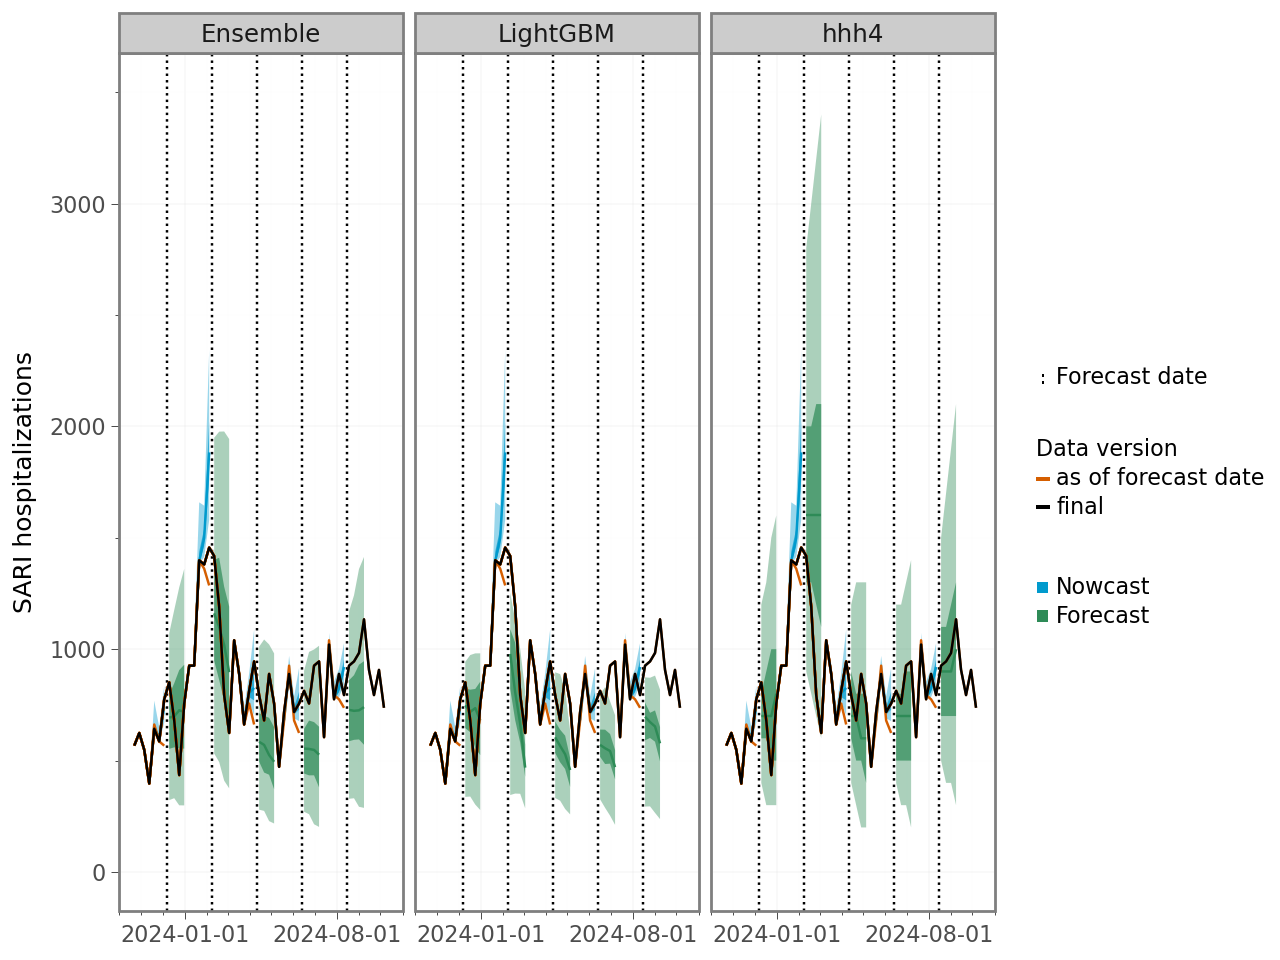

In [71]:
alphas = {"50%": 0.7, "95%": 0.4}

df = df[df.date >= '2023-06-01']

p = (ggplot(df) +
    facet_wrap('model', ncol=3) + 
    geom_vline(
         data=pd.DataFrame({'date': [pd.Timestamp(f) for f in forecast_dates]}),
         mapping=aes(xintercept='date', linetype='"Forecast date"'),
         color="black"
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Nowcast"') # deepskyblue3
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Nowcast"')
     ) +
     geom_line(
         data=df_nowcast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="#009ACD", linetype="solid"
     ) +

    geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Forecast"')
     ) +
     geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Forecast"')
     ) +
     geom_line(
         data=df_forecast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="seagreen", linetype="solid"
     ) +
     geom_line(aes(x='date', y='value', group='forecast_date', color='"as of forecast date"')) +
     geom_line(data=df[df.forecast_date == '2024-10-06'], mapping=aes(x='date', y='value', color='"final"')) +
     theme_bw() +
     labs(x='', y='SARI hospitalizations', linetype='') +
     scale_color_manual(name='\nData version', values={'as of forecast date': '#D55E00', 'final' : 'black'}) +
     scale_fill_manual(name=' ', values={'Forecast': 'seagreen', 'Nowcast': '#009ACD'}) +
     scale_linetype_manual(name=' ', values={'Forecast date': "dotted"}, guide=guide_legend(order=1)) +
     scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)+
     scale_x_date(breaks=[pd.Timestamp('2024-01-01'), pd.Timestamp('2024-08-01')],
                  minor_breaks = '1 month') +
     theme(
         legend_position="right",
         legend_title=element_text(size=8),
         legend_text=element_text(size=8),
         legend_key=element_blank(),
         legend_key_size=5,
         axis_title_y=element_text(size=9),
         axis_text=element_text(size=8),
         axis_ticks=element_line(color="black", size=0.25),
         panel_grid_major=element_line(size=0.15),
         panel_grid_minor=element_line(size=0.1),
         #plot_margin=(1, 1.5, 0, 1.5),
         #legend_margin=5,
         #legend_box_spacing=0
     )  +
     ylim(0, ymax) #35000 
)

p

In [72]:
p.save(f"../figures/forecasts_15-34.pdf", width = 160, height = 55, units="mm", dpi=300)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/forecasts_15-34.pdf


# Multiple shifts in one plot

In [9]:
model = 'KIT-MeanEnsemble'

In [10]:
age_group = '00+'
location = 'DE'
ymax = 38000

In [11]:
DATES = ['2023-12-07', '2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']

df = pd.DataFrame()
df_nowcast = pd.DataFrame()
df_forecast = pd.DataFrame()
df_dates = pd.DataFrame()

for week_shift in range(1, 9):
    print(week_shift)
    dates = increase_dates_by_weeks(DATES, week_shift)

    forecast_dates = dates[:-1]
    df_dates_temp = pd.DataFrame({'forecast_date': forecast_dates, 'shift': week_shift})
    df_dates = pd.concat([df_dates, df_dates_temp])

    dfs = []
    for f in dates:
        ts = load_target_series('sari', f, age_group=age_group)
        df_temp = ts.pd_dataframe().reset_index()
        df_temp['forecast_date'] = f
        dfs.append(df_temp)

    df_temp = pd.concat(dfs)
    df_temp = df_temp.rename(columns={f'icosari-sari-{"DE" if age_group=="00+" else age_group}': 'value'})
    df_temp['shift'] = week_shift
    df = pd.concat([df, df_temp])
    

    nowcasts = []
    for f in forecast_dates:
        df_temp = load_nowcast_wide(f, location, age_group)
        nowcasts.append(df_temp)
    df_nowcast_temp = pd.concat(nowcasts)
    df_nowcast_temp['shift'] = week_shift
    df_nowcast = pd.concat([df_nowcast, df_nowcast_temp])
    
    forecasts = []
    for f in forecast_dates:
        df_temp = load_forecast_wide(f, model, location, age_group)
        forecasts.append(df_temp)
    df_forecast_temp = pd.concat(forecasts)
    df_forecast_temp['shift'] = week_shift
    df_forecast = pd.concat([df_forecast, df_forecast_temp])

1


2


3


4


5


6


7


8


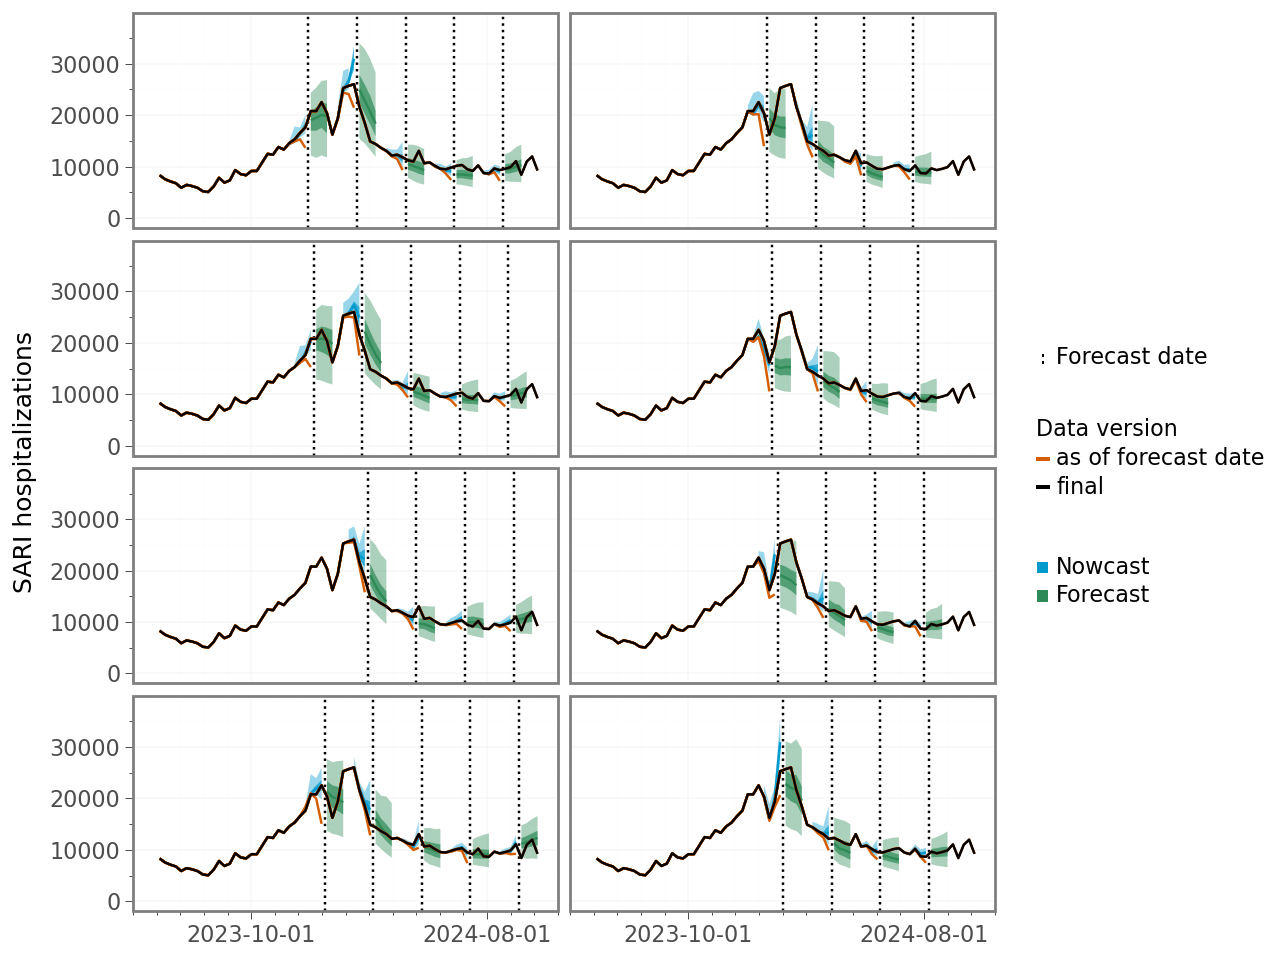

In [12]:
alphas = {"50%": 0.7, "95%": 0.4}

df = df[df.date >= '2023-06-01']

p = (ggplot(df) +
    facet_wrap('shift', ncol=2, dir='v') + 
    geom_vline(
         data=df_dates,
         mapping=aes(xintercept='forecast_date', linetype='"Forecast date"'),
         color="black"
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Nowcast"') # deepskyblue3
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Nowcast"')
     ) +
     geom_line(
         data=df_nowcast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="#009ACD", linetype="solid"
     ) +

    geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Forecast"')
     ) +
     geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Forecast"')
     ) +
     geom_line(
         data=df_forecast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="seagreen", linetype="solid"
     ) +
     geom_line(aes(x='date', y='value', group='forecast_date', color='"as of forecast date"')) +
     geom_line(data=df[df.forecast_date == '2024-10-06'], mapping=aes(x='date', y='value', color='"final"')) +
     theme_bw() +
     labs(x='', y='SARI hospitalizations', linetype='') +
     scale_color_manual(name='\nData version', values={'as of forecast date': '#D55E00', 'final' : 'black'}) +
     scale_fill_manual(name=' ', values={'Forecast': 'seagreen', 'Nowcast': '#009ACD'}) +
     scale_linetype_manual(name=' ', values={'Forecast date': "dotted"}, guide=guide_legend(order=1)) +
     scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)+
     scale_x_date(breaks=[pd.Timestamp('2023-10-01'), pd.Timestamp('2024-08-01')],
                  minor_breaks = '1 month') +
     theme(
         legend_position="right",
         legend_title=element_text(size=8),
         legend_text=element_text(size=8),
         legend_key=element_blank(),
         legend_key_size=5,
         axis_title_y=element_text(size=9),
         axis_text=element_text(size=8),
         axis_ticks=element_line(color="black", size=0.25),
         panel_grid_major=element_line(size=0.15),
         panel_grid_minor=element_line(size=0.1),
         strip_background=element_blank(),  
         strip_text=element_blank()         
         #plot_margin=(1, 1.5, 0, 1.5),
         #legend_margin=5,
         #legend_box_spacing=0
     )  +
     ylim(0, ymax) #35000 
)

p

In [13]:
p.save(f"../figures/ensemble_forecasts.pdf", width = 160, height = 160, units="mm", dpi=300)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 160.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/ensemble_forecasts.pdf


In [14]:
age_group = '00+'
location = 'DE'
ymax = 38000

In [15]:
DATES = ['2023-12-07', '2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']

df = pd.DataFrame()
df_nowcast = pd.DataFrame()
df_forecast = pd.DataFrame()
df_dates = pd.DataFrame()

for week_shift in [0, 5]:
    print(week_shift)
    dates = increase_dates_by_weeks(DATES, week_shift)
    print(dates)
    forecast_dates = dates[:-1]
    df_dates_temp = pd.DataFrame({'forecast_date': forecast_dates, 'shift': week_shift})
    df_dates = pd.concat([df_dates, df_dates_temp])

    dfs = []
    for f in dates:
        ts = load_target_series('sari', f, age_group=age_group)
        df_temp = ts.pd_dataframe().reset_index()
        df_temp['forecast_date'] = f
        dfs.append(df_temp)

    df_temp = pd.concat(dfs)
    df_temp = df_temp.rename(columns={f'icosari-sari-{"DE" if age_group=="00+" else age_group}': 'value'})
    df_temp['shift'] = week_shift
    df = pd.concat([df, df_temp])
    

    nowcasts = []
    for f in forecast_dates:
        df_temp = load_nowcast_wide(f, location, age_group)
        nowcasts.append(df_temp)
    df_nowcast_temp = pd.concat(nowcasts)
    df_nowcast_temp['shift'] = week_shift
    df_nowcast = pd.concat([df_nowcast, df_nowcast_temp])
    
    forecasts = []
    for f in forecast_dates:
        df_temp = load_forecast_wide(f, model, location, age_group)
        forecasts.append(df_temp)
    df_forecast_temp = pd.concat(forecasts)
    df_forecast_temp['shift'] = week_shift
    df_forecast = pd.concat([df_forecast, df_forecast_temp])

0
['2023-12-07', '2024-02-08', '2024-04-11', '2024-06-13', '2024-08-15', '2024-10-06']


5
['2024-01-11', '2024-03-14', '2024-05-16', '2024-07-18', '2024-10-06']


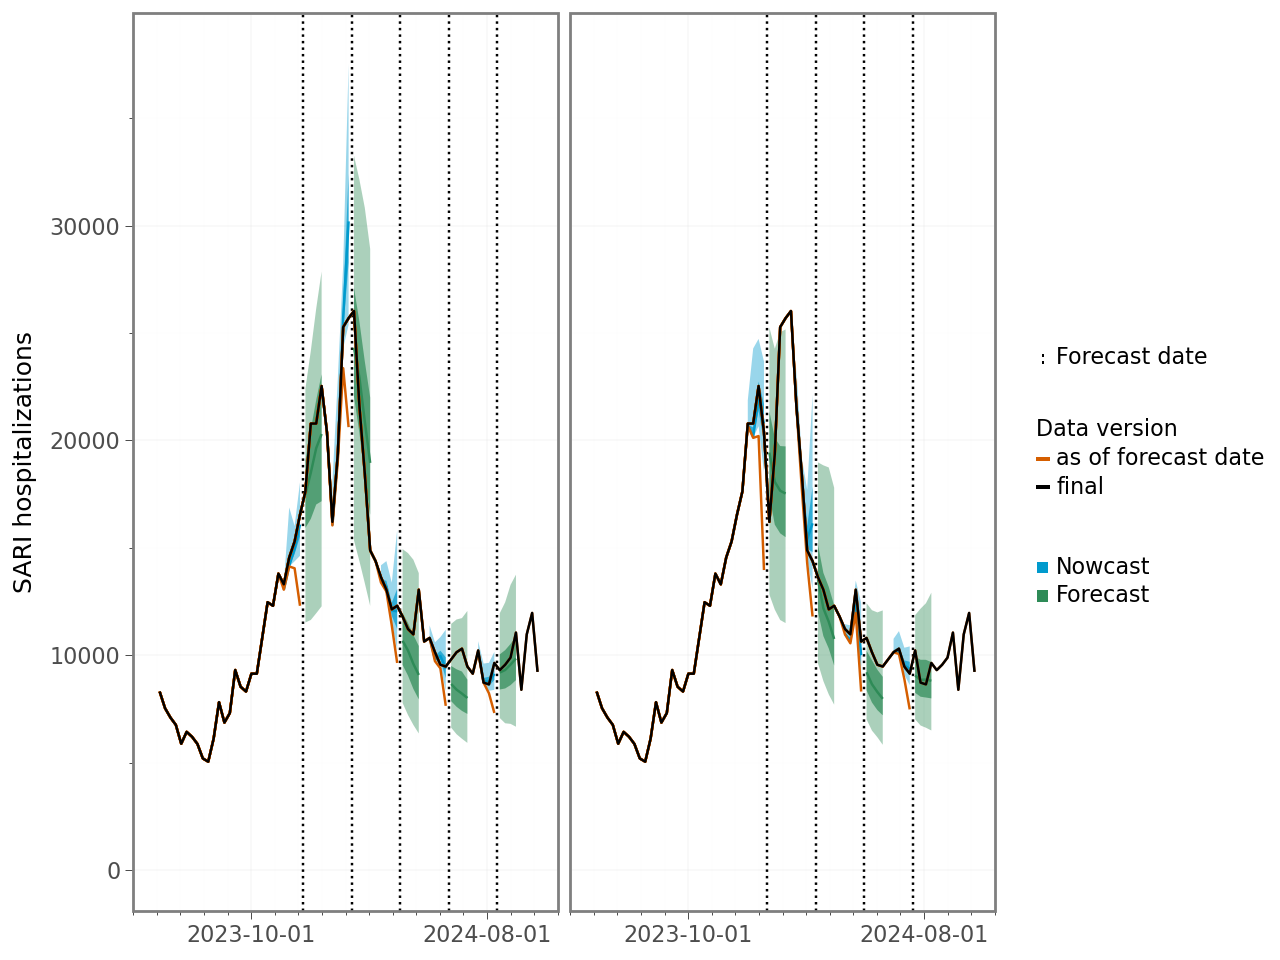

In [16]:
alphas = {"50%": 0.7, "95%": 0.4}

df = df[df.date >= '2023-06-01']

p = (ggplot(df) +
    facet_wrap('shift', ncol=2, dir='v') + 
    geom_vline(
         data=df_dates,
         mapping=aes(xintercept='forecast_date', linetype='"Forecast date"'),
         color="black"
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Nowcast"') # deepskyblue3
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Nowcast"')
     ) +
     geom_line(
         data=df_nowcast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="#009ACD", linetype="solid"
     ) +

    geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"', fill='"Forecast"')
     ) +
     geom_ribbon(
         data=df_forecast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"', fill='"Forecast"')
     ) +
     geom_line(
         data=df_forecast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="seagreen", linetype="solid"
     ) +
     geom_line(aes(x='date', y='value', group='forecast_date', color='"as of forecast date"')) +
     geom_line(data=df[df.forecast_date == '2024-10-06'], mapping=aes(x='date', y='value', color='"final"')) +
     theme_bw() +
     labs(x='', y='SARI hospitalizations', linetype='') +
     scale_color_manual(name='\nData version', values={'as of forecast date': '#D55E00', 'final' : 'black'}) +
     scale_fill_manual(name=' ', values={'Forecast': 'seagreen', 'Nowcast': '#009ACD'}) +
     scale_linetype_manual(name=' ', values={'Forecast date': "dotted"}, guide=guide_legend(order=1)) +
     scale_alpha_manual(name="Forecasts with \nprediction intervals:", values=alphas, guide=None)+
     scale_x_date(breaks=[pd.Timestamp('2023-10-01'), pd.Timestamp('2024-08-01')],
                  minor_breaks = '1 month') +
     theme(
         legend_position="right",
         legend_title=element_text(size=8),
         legend_text=element_text(size=8),
         legend_key=element_blank(),
         legend_key_size=5,
         axis_title_y=element_text(size=9),
         axis_text=element_text(size=8),
         axis_ticks=element_line(color="black", size=0.25),
         panel_grid_major=element_line(size=0.15),
         panel_grid_minor=element_line(size=0.1),
         strip_background=element_blank(),  
         strip_text=element_blank()         
         #plot_margin=(1, 1.5, 0, 1.5),
         #legend_margin=5,
         #legend_box_spacing=0
     )  +
     ylim(0, ymax) #35000 
)

p

In [17]:
p.save(f"../figures/ensemble_forecasts2.pdf", width = 160, height = 55, units="mm", dpi=300)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 55.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/ensemble_forecasts2.pdf
